# Carga de librarias

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px 

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve

from keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Bidirectional, Lambda
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
# Plot del training loss i l'accuracy
def plot_prediction(n_epochs, mfit):
    # TODO
    #Plots 
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,15))

    # plot accuracy during training
    ax[0].set_title('Accuracy')
    ax[0].plot(mfit.history['accuracy'], label='train')
    ax[0].plot(mfit.history['val_accuracy'], label='test')
    ax[0].legend()
    # plot loss during training
    ax[1].set_title('Loss')
    ax[1].plot(mfit.history['loss'], label='train')
    ax[1].plot(mfit.history['val_loss'], label='test')
    ax[1].legend()

def cut_cycles(df, lookback, future, column_features, column_label):
    df_feature = df[column_features]
    df_rul = df[column_label][lookback-1:]

    # Convertimos el dataframe en un numpy array
    numpy_features = df_feature.to_numpy()
    labels = df_rul.to_numpy()
    
    # Creación de listas vacías auxiliares
    features_set = [] 
   
    for i in range(lookback, df.shape[0] - future + 1):
        features_set.append(numpy_features[i - lookback:i]) 

    # Redimensionamiento numpy arrays
    features = np.array(features_set)
    features = np.reshape(features, (features.shape[0], features.shape[1], len(column_features) ))

    return features, labels

def modelo_lstm(input_shape, optimizer):
    model = Sequential()
    model.add(LSTM(units=100, input_shape=input_shape, return_sequences=True))
#     model.add(Dropout(0.2))
    model.add(LSTM(units=30, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
#     model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

def plot_metrics(model, x, y, pred_y):
    y_test_3d_inv = label_scaler.inverse_transform(y_test_3d)
    pred_inv = label_scaler.inverse_transform(pred)

    y_test_list = []
    pred_list = []
    for i in range(pred.shape[0]):
        y_test_list.append(y_test_3d_inv[i][0])
        pred_list.append(round(pred_inv[i][0]))

    print('Accuracy:\t', accuracy_score(y_test_list, pred_list))
    print('Precision:\t', precision_score(y_test_list, pred_list))
    print('Recall:\t\t', recall_score(y_test_list, pred_list))
    print('F1 score:\t', f1_score(y_test_list, pred_list))
    print('ROC AUC score:\t', roc_auc_score(y_test_list, pred_list))

    fig, ax = plt.subplots(2)
    matplotlib.rc('figure', figsize=(15, 10))
    ax[0].plot(y_test_list)
    ax[0].plot(pred_list)
    
    fpr , tpr , thresholds = roc_curve(y_test_list, pred_list)

    ax[1].plot(fpr,tpr) 
    ax[1].axis([0,1,0,1])

---
# Carga de datos

In [5]:
DATA_DIR = "C:/Users/NetRunner/OneDrive/UOC/Semestre 6/TFM/MultipleDatasets"

train_data = pd.read_csv(f"{DATA_DIR}/train_data_uncut.csv")
test_data = pd.read_csv(f"{DATA_DIR}/test_data_uncut.csv")

# X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
# y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")
# X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
# y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

In [6]:
data = pd.concat([train_data, test_data])
features = ['volt','rotate','pressure','vibration','error1','error2','error3','error4','error5', 
            'volt_3h_mean', 'rotate_3h_mean', 'pressure_3h_mean', 'vibration_3h_mean', 'volt_24h_mean',
            'rotate_24h_mean', 'pressure_24h_mean', 'vibration_24h_mean', 'error1_count', 'error2_count', 
            'error3_count', 'error4_count', 'error5_count']
label = ['State']

print(len(train_data))
print(len(test_data))
print(len(data))

40397
8305
48702


In [7]:
feature_scaler = MinMaxScaler(feature_range=(0,1))
label_scaler = MinMaxScaler(feature_range=(0,1))

feature_scaler.fit(data[features])
label_scaler.fit(data[label].values.reshape(-1,1))

MinMaxScaler()

In [8]:
data_norm = data[features+label].copy()
data_norm[features] = feature_scaler.transform(data[features])
data_norm[label] = label_scaler.transform(data[label].values.reshape(-1,1)).astype(int)
data_norm

,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,volt_3h_mean,...,volt_24h_mean,rotate_24h_mean,pressure_24h_mean,vibration_24h_mean,error1_count,error2_count,error3_count,error4_count,error5_count,State
0,0.376540,0.506008,0.329144,0.290724,0.0,0.0,0.0,0.0,0.0,0.258985,...,0.272094,0.372207,0.253195,0.069114,0.000000,0.000000,0.0,0.000000,0.000000,0
1,0.346974,0.394241,0.377751,0.520788,0.0,0.0,0.0,0.0,0.0,0.238611,...,0.244295,0.270370,0.291375,0.278737,0.000000,0.000000,0.0,0.000000,0.000000,0
2,0.414927,0.547666,0.485632,0.340661,0.0,0.0,0.0,0.0,0.0,0.263038,...,0.277623,0.329620,0.360593,0.239197,0.000000,0.000000,0.0,0.000000,0.000000,0
3,0.414022,0.466269,0.203238,0.299181,0.0,0.0,0.0,0.0,0.0,0.280258,...,0.293861,0.322163,0.284295,0.200529,0.000000,0.000000,0.0,0.000000,0.000000,0
4,0.370395,0.496337,0.399222,0.403736,0.0,0.0,0.0,0.0,0.0,0.291018,...,0.287197,0.328647,0.300093,0.215434,0.000000,0.000000,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8300,0.590798,0.475231,0.302635,0.713366,0.0,0.0,0.0,0.0,0.0,0.383354,...,0.450955,0.383491,0.228750,0.602701,0.285714,0.166667,1.0,0.333333,0.333333,1
8301,0.455103,0.397862,0.347602,0.679191,0.0,0.0,0.0,0.0,0.0,0.414840,...,0.448400,0.371331,0.220916,0.617316,0.285714,0.166667,1.0,0.333333,0.333333,1
8302,0.509347,0.509059,0.472205,0.454234,0.0,0.0,0.0,0.0,0.0,0.454524,...,0.442911,0.368975,0.230355,0.604771,0.285714,0.166667,1.0,0.333333,0.333333,1
8303,0.638858,0.588679,0.231742,0.533214,0.0,0.0,0.0,0.0,0.0,0.476603,...,0.456270,0.371157,0.220723,0.602018,0.285714,0.166667,1.0,0.333333,0.333333,1


In [9]:
train_norm = data_norm[:len(train_data)]
test_norm = data_norm[len(train_data):(len(train_data)+len(test_data))]

---
# Modelo LSTM

In [10]:
rangos = 72

train_3d = cut_cycles(train_norm, rangos, 0, features, label)

X_train_3d = train_3d[0]
y_train_3d = train_3d[1]


test_3d = cut_cycles(test_norm, rangos, 0, features, label)

X_test_3d = test_3d[0]
y_test_3d = test_3d[1]

print('X_train_3d:\t', X_train_3d.shape)
print('y_train_3d:\t', y_train_3d.shape)
print('X_test_3d:\t', X_test_3d.shape)
print('y_test_3d:\t', y_test_3d.shape)

X_train_3d:	 (40326, 72, 22)
y_train_3d:	 (40326, 1)
X_test_3d:	 (8234, 72, 22)
y_test_3d:	 (8234, 1)


In [10]:
%%time
epochs = [100]
batches = [8, 16]
optimizers = ['adam', 'rmsprop']
lrs = [0.01, 0.001, 0.0001] 
input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])

for epoch in epochs:
    for batch in batches:
        for opt in optimizers:
            for lr in lrs:
                if opt == 'adam':
                    optimizer = Adam(learning_rate=lr)
                elif opt == 'rmsprop':
                    optimizer = RMSprop(learning_rate=lr)
                
                model = modelo_lstm(input_shape, optimizer)
                
                print('=========Training model==========')

                print('Hiperparámetros:')
                print('Optimizer:\t', opt)
                print('Learning Rate:\t', lr)
                print('Epochs:\t\t', epoch)
                print('Batch:\t\t', batch)
                
                res_m = model.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=epoch, batch_size=batch, verbose = 0, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)])
                
                pred = model.predict(X_test_3d)
                y_test_3d_inv = label_scaler.inverse_transform(y_test_3d)
                pred_inv = label_scaler.inverse_transform(pred)

                y_test_list = []
                pred_list = []
                for i in range(pred_inv.shape[0]):
                    y_test_list.append(y_test_3d_inv[i][0])
                    pred_list.append(round(pred_inv[i][0]))

                print('Accuracy:\t', accuracy_score(y_test_list, pred_list))
                print('Precision:\t', precision_score(y_test_list, pred_list))
                print('Recall:\t\t', recall_score(y_test_list, pred_list))
                print('F1 score:\t', f1_score(y_test_list, pred_list))
                print('ROC AUC score:\t', roc_auc_score(y_test_list, pred_list))
                
                print('=================================\n')

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.01
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
111/111 [==============================] - 2s 13ms/step
Accuracy:	 0.9175403797109662
Precision:	 0.6504065040650406
Recall:		 0.4383561643835616
F1 score:	 0.5237315875613747
ROC AUC score:	 0.7055876902828049

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.001
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
111/111 [==============================] - 2s 17ms/step
Accuracy:	 0.9155568149617456
Precision:	 0.6425531914893617
Recall:		 0.4136986301369863
F1 score:	 0.5033333333333333
ROC AUC score:	 0.6935749787853073

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.0001
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 3.
Epo

In [11]:
epochs = 100
optimizer = RMSprop(learning_rate=0.01)
input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])

model = modelo_lstm(input_shape, optimizer)

res_m = model.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=epochs, batch_size=16, verbose = 1, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min', restore_best_weights=True)])


Epoch 1/100
2521/2521 [==============================] - 87s 34ms/step - loss: 0.2062 - accuracy: 0.9418 - val_loss: 0.2319 - val_accuracy: 0.9345
Epoch 2/100
2521/2521 [==============================] - 78s 31ms/step - loss: 0.1817 - accuracy: 0.9491 - val_loss: 0.2401 - val_accuracy: 0.9315
Epoch 3/100
2521/2521 [==============================] - 79s 31ms/step - loss: 0.1769 - accuracy: 0.9519 - val_loss: 0.2251 - val_accuracy: 0.9402
Epoch 4/100
2521/2521 [==============================] - 80s 32ms/step - loss: 0.1716 - accuracy: 0.9542 - val_loss: 0.2198 - val_accuracy: 0.9384
Epoch 5/100
2521/2521 [==============================] - 81s 32ms/step - loss: 0.1712 - accuracy: 0.9554 - val_loss: 0.2653 - val_accuracy: 0.9336
Epoch 6/100
2521/2521 [==============================] - 80s 32ms/step - loss: 0.1877 - accuracy: 0.9514 - val_loss: 0.2648 - val_accuracy: 0.9304
Epoch 7/100
2521/2521 [==============================] - 81s 32ms/step - loss: 0.1828 - accuracy: 0.9527 - val_loss: 0

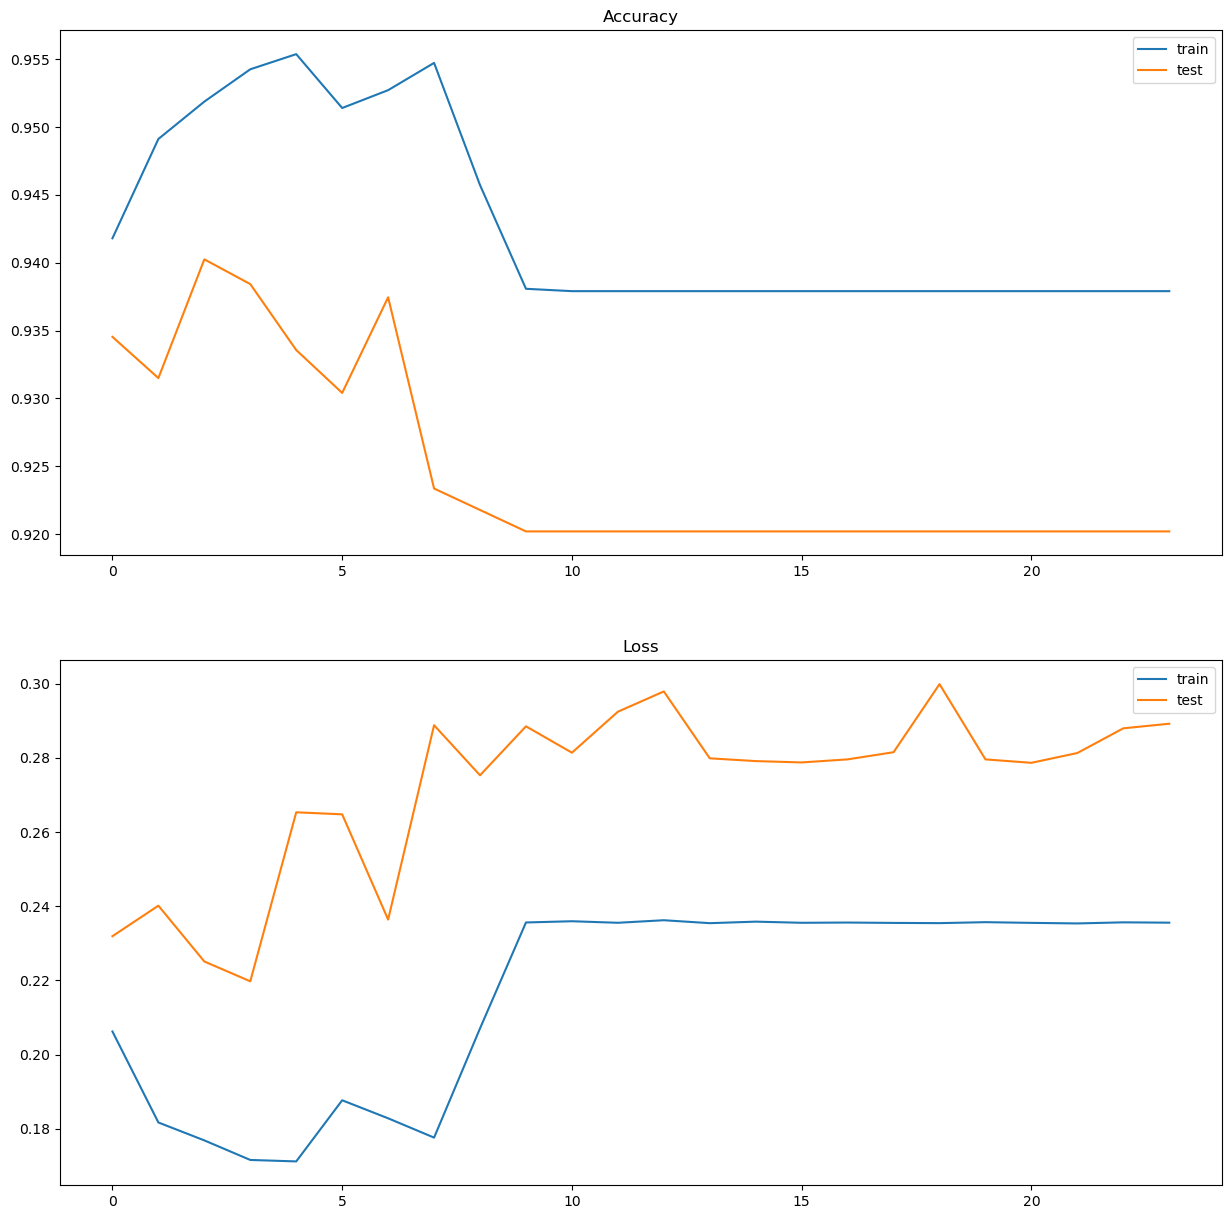

In [12]:
plot_prediction(epochs, res_m)

258/258 [==============================] - 4s 14ms/step


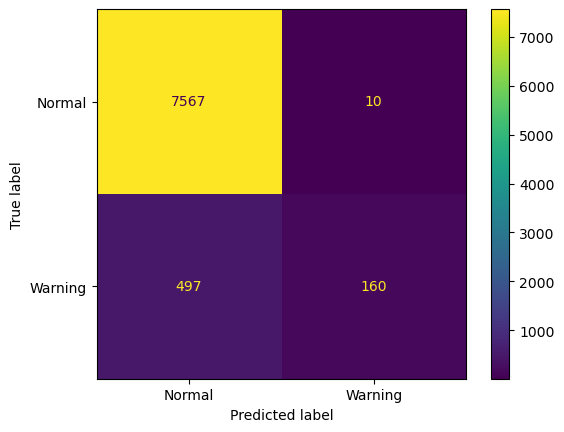

In [13]:
y_test_3d_inv = label_scaler.inverse_transform(y_test_3d)
y_test_list = []
pred = model.predict(X_test_3d)
pred_inv = label_scaler.inverse_transform(pred)

pred_list = []
for i in range(pred.shape[0]):
    y_test_list.append(y_test_3d_inv[i][0])
    pred_list.append(round(pred_inv[i][0]))
    
lr_cm = confusion_matrix(y_test_list, pred_list)
ConfusionMatrixDisplay(lr_cm, display_labels=['Normal', 'Warning']).plot()

Accuracy:	 0.9384260383774593
Precision:	 0.9411764705882353
Recall:		 0.243531202435312
F1 score:	 0.38694074969770254
ROC AUC score:	 0.6211057094399075


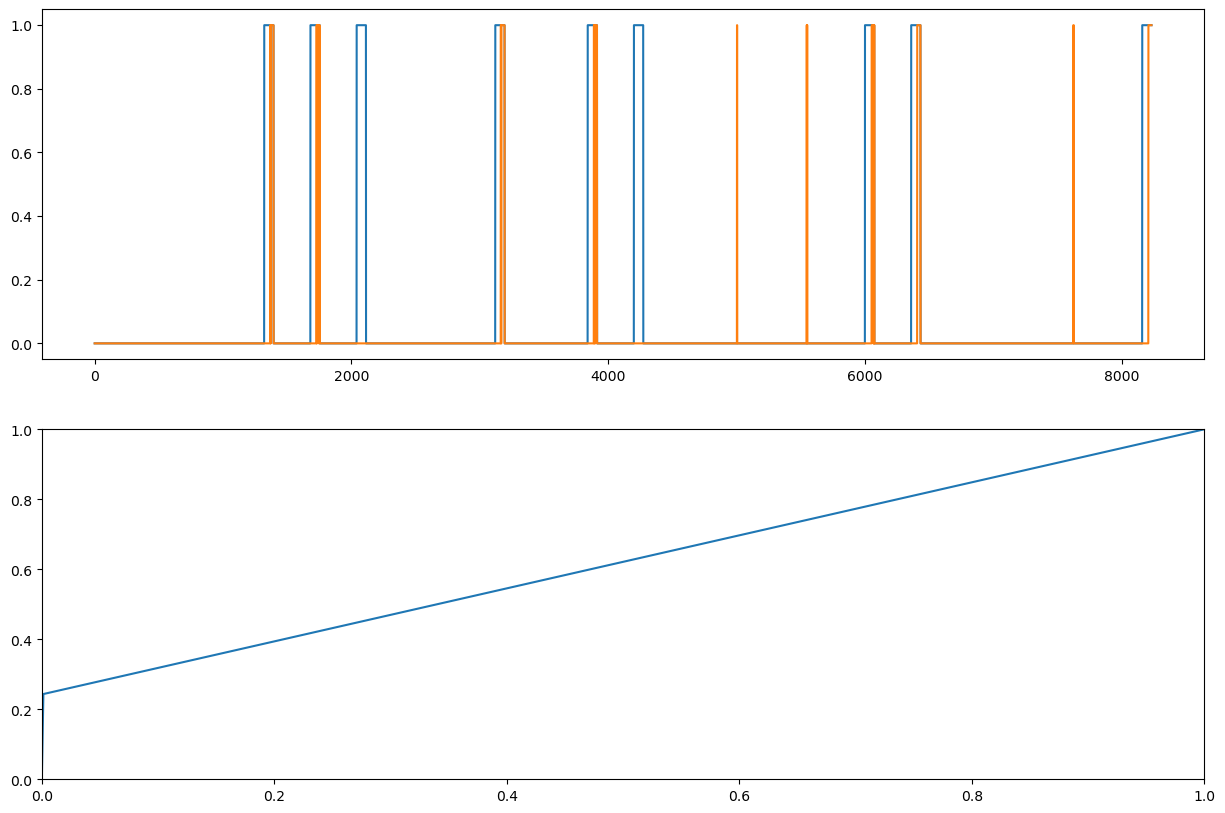

In [15]:
plot_metrics(model, X_test_3d, y_test_3d, pred)